<a href="https://colab.research.google.com/github/maritverboom/TM10007_PROJECT/blob/master/assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TM10007 Assignment 


In [0]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/karinvangarderen/tm10007_project.git

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Feature selection
from sklearn import feature_selection
# Univariate
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import GenericUnivariateSelect
# Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from yellowbrick.regressor import AlphaSelection
from yellowbrick.datasets import load_concrete
from sklearn.feature_selection import SelectFromModel

# Classifiers
from sklearn import model_selection
from sklearn import metrics
from sklearn import preprocessing
from sklearn import neighbors
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier

## Data Loading

In [0]:
from hn.load_data import load_data
data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

# Splitting the data in train- and testpart with a portion of 'test_size' testing data (20%)
data_train, data_test = model_selection.train_test_split(data, test_size=0.20, stratify=data['label'])

print(f'The number of rows of train data : {len(data_train.index)}')
print(f'The number of rows of test data : {len(data_test.index)}')

# dataframe containing tumor stadium of subject (T12/T34)
stage_train = data_train['label']             
stage_test = data_test['label'] 

# dataframe containing all feature columns except 'label' (tumor stadium of subject)
data_train = data_train.drop(columns='label') 
data_test = data_test.drop(columns='label')

# Binarize label data
stage_train = preprocessing.label_binarize(stage_train, ['T12', 'T34'])
stage_train = [i[0] for i in stage_train]
stage_test = preprocessing.label_binarize(stage_test, ['T12', 'T34'])
stage_test = [i[0] for i in stage_test]



The number of samples: 113
The number of columns: 160
The number of rows of train data : 90
The number of rows of test data : 23


## Data cleaning


In [0]:
# Imputation
#imp = SimpleImputer(missing_values=np.nan, strategy='median')
#imp.fit(data_train)
#data_train = imp.transform(data_train)
#data_test = imp.transform(data_test)

# Remove all columns where more than 25% of the values are 0.0
drop_cols_train = data_train.columns[(data_train == 0).sum() > 0.25*data_train.shape[1]]
drop_cols_test = data_test.columns[(data_train ==0).sum() > 0.25*data_train.shape[1]]
data_train.drop(drop_cols_train, axis = 1, inplace = True) 
data_test.drop(drop_cols_test, axis = 1, inplace = True)
print(f'The number of columns after preprocessing: {len(data_train.columns)}')
print(f'The number of columns after preprocessing: {len(data_test.columns)}')


# Remove all columns with no std
drop_std_train = data_train.columns[data_train.std() == 0]
drop_std_test = data_test.columns[data_train.std() == 0]
data_train.drop(drop_std_train, axis = 1, inplace = True) 
data_test.drop(drop_std_test, axis = 1, inplace = True)

print(f'TRAIN: The number of columns after preprocessing: {len(data_train.columns)}, and the number of rows: {len(data_train.index)}')
print(f'TEST: The number of columns after preprocessing: {len(data_test.columns)},  and the number of rows: {len(data_test.index)}')


The number of columns after preprocessing: 152
The number of columns after preprocessing: 152
TRAIN: The number of columns after preprocessing: 149, and the number of rows: 90
TEST: The number of columns after preprocessing: 149,  and the number of rows: 23


## Data Scaling


StandardScaler removes the mean and scales the data to unit variance.  cannot guarantee balanced feature scales in the presence of outliers.

MinMaxScaler rescales the data set such that all feature values are in the range [0, 1], very sensitive to outliers

Robust scaler. Unlike the previous scalers, the centering and scaling statistics of this scaler are based on percentiles and are therefore not influenced by a few number of very large marginal outliers.
 

In [0]:
# Scale the data (train on train set)
scaler = preprocessing.StandardScaler()   
scaler.fit(data_train)  

# Perform scaling on both train and testset
data_train_scaled = scaler.transform(data_train)
data_test_scaled = scaler.transform(data_test) 

## Preprocessing: Feature selection/extraction

- Recursive Feature Elimination
- Univariate Feature Selection
- Principal Component Analysis
- L1/Lasso Regression Feature Selection

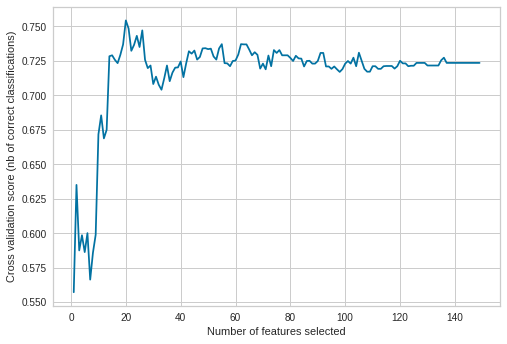

Num Features: 20
Selected Features: [False  True  True False False False False False  True False  True False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False  True False  True False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False  True False False False False  True False False False
 False False  True  True  True False False False False False False False
 False False False False False  True False False False False  True False
  True  True False False False  True False False False False False False
 False False False False False False False False  True False False False
 False False False False  True False False False  True False False False
 False False False  True False]
Feature Ranking: [ 37   1   1   2  82  53  92  13   1 11

In [0]:
# Recursive Feature Elimination
svc = svm.SVC(kernel="linear")  # Create the RFE object and compute a cross-validated score.

# classifications
rfecv = feature_selection.RFECV(
    estimator=svc, step=1, 
    cv=model_selection.StratifiedKFold(4),
    scoring='roc_auc')
fit_rfecv = rfecv.fit(data_train_scaled, stage_train)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

print("Num Features: %d" % fit_rfecv.n_features_)
print("Selected Features: %s" % fit_rfecv.support_)
print("Feature Ranking: %s" % fit_rfecv.ranking_)

data_train_rfecv = rfecv.transform(data_train_scaled)
data_test_rfecv = rfecv.transform(data_test_scaled)

print(data_train_rfecv.shape)
print(data_test_rfecv.shape)

##  Feature selection using univariate feature selection

In [0]:
# Eventuele hyperparameters die nog kunnen worden aangepast: methodes voor univariate feature selection (selectKBest, SelectPercentile, en nog meer),
# methodes om 'best' te bepalen chi2, f_classif, mutual_info_classif
# aantal features dat je selecteert, getal voor percentile, getal voor k-best, etc.
# Dit kan misschien automatisch met genericUnivariateSelect(), zie hieronder

# selector = GenericUnivariateSelect()
# __init__(self, score_func=<function f_classif at 0x7ffa31b6a8b0>, mode='percentile', param=1e-05)
# fit_uni = selector.fit(self, data_train_scaled, stage_train)
# data_train_uni = selector.transform(self, data_train_scaled)
# data_test_uni = selector.transform(self, data_test_scaled)

selector = SelectPercentile(f_classif, percentile=10)
fit_uni = selector.fit(data_train_scaled, stage_train)
data_train_uni = selector.transform(data_train_scaled)
data_test_uni = selector.transform(data_test_scaled)

# print("Feature Ranking: %s" % fit_uni.scores_)

print(data_train_uni.shape)
print(data_test_uni.shape)

(90, 15)
(23, 15)


## Principal Component Analysis (PCA)


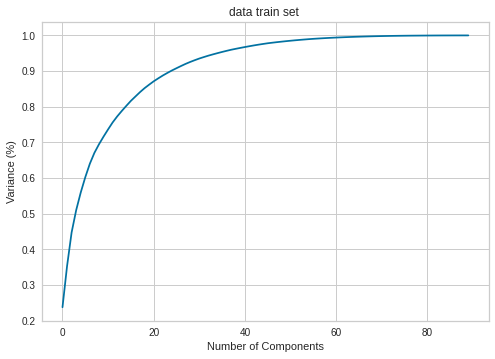

(90, 55)
(23, 55)


In [0]:

# Create a function for calculating PCA
def pca(data_train, data_test):
    """
    Function for PCA

        data_train = training data
        data_test = testing data

    Output is transformed train- and testdata
    """
    pca=PCA().fit(data_train)
    var = np.cumsum(pca.explained_variance_ratio_)
    n_comp = np.where(var>0.99)[0][0]

    pca_train = PCA(n_components=n_comp)
    pca_train.fit(data_train)

    # Transform data using PCA
    data_train_trans = pca_train.transform(data_train)
    data_test_trans = pca_train.transform(data_test)
    
    plt.figure()
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Variance (%)') # for each component
    plt.title('data train set ')
    plt.show()
#print(np.cumsum(pca.explained_variance_ratio_))

    # Return transformed train- and testdata
    return data_train_trans, data_test_trans

data_train_pca, data_test_pca = pca(data_train_scaled, data_test_scaled)
print(data_train_pca.shape)
print(data_test_pca.shape)



## Lasso feature selection


The optimal alpha = 0.039035278878871385
Selected 19 from 149 features.


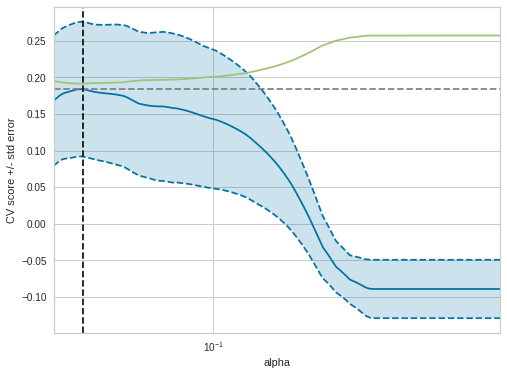

In [0]:
lasso = Lasso(max_iter=10000)
n_alphas = 200
alphas = np.logspace(-1.5, -0.1, n_alphas)

tuned_parameters = [{'alpha': alphas}]
n_folds = 5

clf = GridSearchCV(lasso, tuned_parameters, cv=n_folds, refit=False)
clf.fit(data_train_scaled, stage_train)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']
plt.figure().set_size_inches(8, 6)
plt.semilogx(alphas, scores)

# plot error lines showing +/- std. errors of the scores
std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(alphas, scores + std_error, 'b--')
plt.semilogx(alphas, scores - std_error, 'b--')

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])

# Instantiate the linear model and visualizer
model = LassoCV(alphas=alphas)
visualizer = AlphaSelection(model)
visualizer.fit(data_train_scaled, stage_train)
#visualizer.show()

alpha_best = model.alpha_
print(f'The optimal alpha = {alpha_best}')

#L1_selection = Lasso(alpha=alpha_best, max_iter=10000)
#L1_selection.fit(data_train_scaled, stage_train)
#train_score=L1_selection.score(data_train_scaled,stage_train)
#coeff_used = np.sum(L1_selection.coef_!=0)
#print("training score:", train_score) 
#print("number of features used: ", coeff_used)

selector = SelectFromModel(estimator=Lasso(alpha=alpha_best, random_state = 42))
selector.fit(data_train_scaled, stage_train)
n_original = data_train_scaled.shape[1]
data_train_l1 = selector.transform(data_train_scaled)
data_test_l1 = selector.transform(data_test_scaled)
n_selected = data_train_l1.shape[1]
print(f"Selected {n_selected} from {n_original} features.")



In [0]:
# All feature selections in a list, can be used for all classifications  
data_train_fs = [data_train_rfecv, data_train_uni, data_train_pca, data_train_l1] 
data_test_fs = [data_test_rfecv, data_test_uni, data_test_pca, data_test_l1]   


# L2/ridge classifier

In [0]:
ridge = RidgeClassifier(max_iter=10000)
n_alphas = 200
alphas = np.logspace(-1.5, -0.1, n_alphas)

tuned_parameters = [{'alpha': alphas}]
n_folds = 5

clf = GridSearchCV(ridge, tuned_parameters, cv=n_folds, refit=False)
clf.fit(data_train_scaled, stage_train)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']
plt.figure().set_size_inches(8, 6)
plt.semilogx(alphas, scores)

# plot error lines showing +/- std. errors of the scores
std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(alphas, scores + std_error, 'b--')
plt.semilogx(alphas, scores - std_error, 'b--')

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])

# Instantiate the linear model and visualizer
model = RidgeCV(alphas=alphas)
visualizer = AlphaSelection(model)
visualizer.fit(data_train_scaled, stage_train)
#visualizer.show()

alpha_best = model.alpha_
print(f'The optimal alpha = {alpha_best}')

#L1_selection = Ridge(alpha=alpha_best, max_iter=10000)
#L1_selection.fit(data_train_scaled, stage_train)
#train_score=L1_selection.score(data_train_scaled,stage_train)
#coeff_used = np.sum(L1_selection.coef_!=0)
#print("training score:", train_score) 
#print("number of features used: ", coeff_used)

selector = SelectFromModel(estimator=Ridge(alpha=alpha_best, random_state = 42))
selector.fit(data_train_scaled, stage_train)
n_original = data_train_scaled.shape[1]
data_train_l1 = selector.transform(data_train_scaled)
data_test_l1 = selector.transform(data_test_scaled)
n_selected = data_train_l1.shape[1]
print(f"Selected {n_selected} from {n_original} features.")

## kNN


In [0]:
def knn_classifier(leaf_size, p, n_neigbors, weights, data_train, data_test, label_train, label_test):
    """
    Function for kNN training and testing

        data_train =  training data (type = list)
        data_test_trans = testing data (type = list)
        label_train = class of training data (type = list)
        label_test = class of testing data (type = list)
        
    Output is two lists with the predicted class of the train- and testdata 
    """
    knn = neighbors.KNeighborsClassifier(leaf_size = leaf_size, weights = weights, n_neighbors = n_neigbors, p = p)
    knn.fit(data_train, label_train)
    label_train_knn = knn.predict(data_train)
    label_test_knn = knn.predict(data_test)
    score_train = knn.score(data_train, label_train)
    score_test = knn.score(data_test, label_test)
    return score_train, score_test, label_train_knn, label_test_knn


# Hyperparameters optimization 
leaf_size = list(range(1,50))
n_n = list(range(1,50))
p=[1,2]
weights = ['uniform', 'distance']

hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_n, p=p, weights = weights)
knn_tune = neighbors.KNeighborsClassifier()
clf_tune_knn = model_selection.RandomizedSearchCV(knn_tune, hyperparameters, n_iter = 30, cv=10)

# for loop for caluculation score and stage with the different feature selections
score_train_knn = []
score_test_knn = []
stage_train_knn = []
stage_test_knn = []

for df, df_test in zip(data_train_fs, data_test_fs):
    best_model = clf_tune_knn.fit(df, stage_train)

    leaf_size_best = best_model.best_estimator_.get_params()['leaf_size']
    p_best = best_model.best_estimator_.get_params()['p']
    n_n_best = best_model.best_estimator_.get_params()['n_neighbors']
    weights_best = best_model.best_estimator_.get_params()['weights']
   
    score_train, score_test, stage_train, stage_test = knn_classifier(leaf_size_best, 
                        p_best, n_n_best, weights_best, df, df_test, stage_train, stage_test)

    score_train_knn.append(score_train)
    score_test_knn.append(score_test)
    stage_train_knn.append(stage_train)
    stage_test_knn.append(stage_test)

print(f'Accuracy of classifier on traindata: {score_train_knn}') # accuracy
print(f'Accuracy of classifier on testdata: {score_test_knn}') # accuracy
print(stage_train_knn)
print(stage_test_knn)





Accuracy of classifier on traindata: [1.0, 0.9888888888888889]
Accuracy of classifier on testdata: [0.8260869565217391, 0.8260869565217391]
[array([1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0,
       0, 1]), array([1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0,
       0, 1])]
[array([1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1]), array([0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0])]


## Support Vector Machine (SVM)
-  Geeft nu alleen een kernel mee, maar heeft nog veel meer parameters
- test_decision = svc.decision_function(data_test) kunnen we later miss nog gebruiken om een ROC te maken

In [0]:
# List with hyperparameters that we want to tune.
kernels = ['linear', 'poly', 'rbf']
gammas = [0.1, 1, 10, 100]
cs = [0.1, 1, 10, 100, 1000]
degrees = [0, 1, 2, 3, 4, 5, 6] # use only for 'poly'

hyperparameters = dict(kernel = kernels, gamma = gammas, C = cs, degree = degrees)

# Create new KNN object
svm_tune = svm.SVC()

# Use Randomized Search
# Als je GridSearch gebruikt, komt er telkens hetzelfde uit. 
clf_tune_svm = model_selection.RandomizedSearchCV(svm_tune, hyperparameters, n_iter = 30, cv=10)


#Fit the model
best_model_svm = clf_tune_svm.fit(data_train_l1, stage_train)

kernel_best = best_model_svm.best_estimator_.get_params()['kernel']
gamma_best = best_model_svm.best_estimator_.get_params()['gamma']
c_best = best_model_svm.best_estimator_.get_params()['C']
degree_best = best_model_svm.best_estimator_.get_params()['degree']

#Print The value of best Hyperparameters
print('Best kernel:', kernel_best)
print('Best gamma:', gamma_best)
print('Best C:', c_best)
print('Best degree:', degree_best)


def svm_classifier(C, kernel, degree, gamma, data_train, data_test, label_train, label_test, svm_kernel):
    """
    Function for SVM training and testing

        data_train =  training data (type = list)
        data_test_trans = testing data (type = list)
        label_train = class of training data (type = list)
        label_test = class of testing data (type = list)
        svm_kernel = different kernels to be used (type = string)

    Output is two lists with the predicted class of the train- and testdata
    """
    svc = svm.SVC(C=C, kernel=kernel, degree=degree, gamma=gamma)
    svc.fit(data_train, label_train)

    # Predict the classes of the data 
    label_train_svm = svc.predict(data_train)
    label_test_svm= svc.predict(data_test)

    score_train = svc.score(data_train, label_train)
    score_test = svc.score(data_test, label_test)
    
    return label_train_svm, label_test_svm, score_train, score_test

stage_train_svm, stage_test_svm, score_train_svm, score_test_svm = svm_classifier(c_best, kernel_best, degree_best, gamma_best, data_train_l1, data_test_l1, stage_train, stage_test, 'linear')
print(f'Accuracy of classifier on traindata: {score_train_svm}') # accuracy
print(f'Accuracy of classifier on testdata: {score_test_svm}') # accuracy

Best kernel: linear
Best gamma: 100
Best C: 1
Best degree: 1
Accuracy of classifier on traindata: 0.9111111111111111
Accuracy of classifier on testdata: 0.6521739130434783


## Random Forest Classifier 
- n_estomators: number of tress in forest, default is 10
- max_depth: maximum depth of tree 
- min_samples_split: minn number of samples required to split an internal node
- max_featrues: number of features consider when looking fot the best split 
- bootstrap
- class_weight  




In [0]:
# Hyperparameters that we want to tune 
n_estimators = [10, 30, 50, 100, 300]     #, 500, 800, 1200] [500, 800, 1500, 2500, 500]
max_depth = [5, 10, 15, 20, 30]                # [10, 20, 30, 40, 50]
min_samples_split = [2, 7, 10, 12, 20]       #[2, 5, 10, 15, 20]
min_samples_leaf = [1, 5, 10, 15, 20]              #[1, 2, 5, 10, 15]
bootstrap = [True, False]
class_weight = [{0: 1, 1: 0.001}, {0: 1, 1: 1}, {0: 1, 1: 10}, {0: 1, 1: 100}]



hyperparameters_rfc = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf, bootstrap = bootstrap, 
             class_weight = class_weight)

rfc_tune = RandomForestClassifier()

clf_tune_rfc = model_selection.RandomizedSearchCV(rfc_tune, hyperparameters_rfc, n_iter = 30, cv=5)
#n_iter = 500, cv = 5, verbose= 2, random_state=42, n_jobs = -1


#Fit the model
best_model_rfc = clf_tune_rfc.fit(data_train_l1, stage_train)


n_estimators_best = best_model_rfc.best_estimator_.get_params()['n_estimators']
max_depth_best = best_model_rfc.best_estimator_.get_params()['max_depth']
min_samples_split_best = best_model_rfc.best_estimator_.get_params()['min_samples_split']
min_samples_leaf_best = best_model_rfc.best_estimator_.get_params()['min_samples_leaf']
bootstrap_best = best_model_rfc.best_estimator_.get_params()['bootstrap']
class_weight_best = best_model_rfc.best_estimator_.get_params()['class_weight']


#Print The value of best Hyperparameters
print('Best n_estimators:', n_estimators_best)
print('Best max_depth:', max_depth_best)
print('Best min_samples_split:', min_samples_split_best)
print('Best min_samples_leaf:', min_samples_leaf_best)
print('Best bootstrap', bootstrap_best)
print('Best class_weight', class_weight_best)


def rfc_classifier(n_estimators, max_depth, min_samples_split, min_samples_leaf, 
                   bootstrap, class_weight, data_train, data_test, label_train, 
                   label_test):
    """
    Function for RFC training and testing

        data_train =  training data (type = list)
        data_test_trans = testing data (type = list)
        label_train = class of training data (type = list)
        label_test = class of testing data (type = list)
        
    Output is two lists with the predicted class of the train- and testdata 
    """
    # Create Random Forest Classifier and fit classifier on traindata
    rfc = RandomForestClassifier(n_estimators = n_estimators, max_depth = 
              max_depth, min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf, bootstrap = bootstrap,
             class_weight = class_weight)
    rfc.fit(data_train, label_train)

    # Predict labels for train- and testdata
    label_train_rfc = rfc.predict(data_train)
    label_test_rfc = rfc.predict(data_test)
    
    score_train = rfc.score(data_train, label_train)
    score_test = rfc.score(data_test, label_test)

    return label_train_rfc, label_test_rfc, score_train, score_test

stage_train_rfc, stage_test_rfc, score_train_rfc, score_test_rfc = rfc_classifier(
    n_estimators_best, max_depth_best, min_samples_split_best, 
    min_samples_leaf_best, bootstrap_best, class_weight_best,
    data_train_l1, data_test_l1, stage_train, stage_test)
print(f'Accuracy of classifier on traindata: {score_train_rfc}') # accuracy
print(f'Accuracy of classifier on testdata: {score_test_rfc}') # accuracy



## Neural network


*   Classifier obv neural network
*   Met cross validatie selectie van de juiste hyperparameters: hidden_layer_sizes, activation, solver, alpha, learning_rate, batch_size. Eventueel tunen op nog meer hyperparameters?
*   Getuned mbv randomized search



In [0]:
# Hyperparameters that we want to tune 

hyperparameters_neural_network = {'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
                                  'activation': ['tanh', 'relu','identity', 'logistic'], 
                                  'solver': ['lbfgs', 'sgd', 'adam'],
                                  'alpha':[0.0001, 0,005, 0.05],
                                  'learning_rate':['constant', 'adaptive'],
                                  'batch_size':[5, 10, 15, 20, 25]}
neural_network_tune = MLPClassifier()
clf_tune_neural_network = model_selection.RandomizedSearchCV(neural_network_tune, hyperparameters_neural_network, n_iter = 30, cv=5)

# fit the model
best_model_neural_network = clf_tune_neural_network.fit(data_train_l1, stage_train)

# get best values
hidden_layer_sizes_best = best_model_neural_network.best_estimator_.get_params()['hidden_layer_sizes']
activation_best = best_model_neural_network.best_estimator_.get_params()['activation']
solver_best = best_model_neural_network.best_estimator_.get_params()['solver']
alpha_best = best_model_neural_network.best_estimator_.get_params()['alpha']
learning_rate_best = best_model_neural_network.best_estimator_.get_params()['learning_rate']
batch_size_best = best_model_neural_network.best_estimator_.get_params()['batch_size']

#Print The value of best Hyperparameters
print('Best hidden_layer_sizes:', hidden_layer_sizes_best)
print('Best activation:', activation_best)
print('Best solver:', solver_best)
print('Best alpha:', alpha_best)
print('Best learning_rate', learning_rate_best)
print('Best batch_size', batch_size_best)


def neural_network_classifier(hidden_layer_sizes, activation, solver, alpha, learning_rate, batch_size, data_train, data_test, label_train, 
                   label_test):
    """
    Function for neural network training and testing

        data_train =  training data (type = list)
        data_test_trans = testing data (type = list)
        label_train = class of training data (type = list)
        label_test = class of testing data (type = list)
        
    Output is two lists with the predicted class of the train- and testdata 
    """
    # Create neural network Classifier and fit classifier on traindata
    neural_network = MLPClassifier(hidden_layer_sizes = hidden_layer_sizes, activation = 
              activation, solver = solver, 
             alpha = alpha, learning_rate = learning_rate,
             batch_size = batch_size)
    neural_network.fit(data_train, label_train)

    # Scores and predicted labels of neural network classifier
    label_train_neural_network = neural_network.predict(data_train)
    label_test_neural_network = neural_network.predict(data_test)
    
    score_train_neural_network = neural_network.score(data_train, label_train)
    score_test_neural_network = neural_network.score(data_test, label_test)

    return label_train_neural_network, label_test_neural_network, score_train_neural_network, score_test_neural_network

# neural_network = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(15,), random_state=1)
# neural_network.fit(data_train_l1, stage_train)

# score_train_neural_network = neural_network.score(data_train_l1, stage_train)
# score_test_neural_network = neural_network.score(data_test_l1, stage_test)
label_train_neural_network, label_test_neural_network, score_train_neural_network, score_test_neural_network = neural_network_classifier(
    hidden_layer_sizes_best, activation_best, solver_best, 
    alpha_best, learning_rate_best, batch_size_best,
    data_train_l1, data_test_l1, stage_train, stage_test)
print(f'Accuracy of neural network classifier on traindata: {score_train_neural_network}') # accuracy
print(f'Accuracy of neural network classifier on testdata: {score_test_neural_network}') # accuracy


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Best hidden_layer_sizes: (50, 100, 50)
Best activation: logistic
Best solver: lbfgs
Best alpha: 0.0001
Best learning_rate constant
Best batch_size 20
Accuracy of neural network classifier on traindata: 0.7888888888888889
Accuracy of neural network classifier on testdata: 0.782608695652174


## Performance
- Functie gemaakt om een dataframe te maken van de performance van een bepaalde classifier
- Uiteindelijke mooier om alles er tegelijk in te kunnen gooien met een loop en dan 1 groot dataframe te maken

In [0]:
def performance_clf(predlabel_train, label_train, predlabel_test, label_test):
    """
    Function to calculate performance of a classifier:

        predlabel_train = predicted label of traindata 
        label_train = real label of traindata
        predlabel_test = predicted label of testdata
        label_test = real label of testdata
    
    This function returns a dataframe of the calculated AUC, accuracy, F1-score,
    precision and recall of the classifier for the train- and testdata
    """
    
    # Performance train set
    auc_train=metrics.roc_auc_score(predlabel_train, label_train)
    accuracy_train=metrics.accuracy_score(predlabel_train, label_train)
    F1_train=metrics.f1_score(predlabel_train, label_train)
    precision_train=metrics.precision_score(predlabel_train, label_train)
    recall_train=metrics.recall_score(predlabel_train, label_train)
    
    # Performance test set
    auc_test=metrics.roc_auc_score(predlabel_test, label_test)
    accuracy_test=metrics.accuracy_score(predlabel_test, label_test)
    F1_test=metrics.f1_score(predlabel_test, label_test)
    precision_test=metrics.precision_score(predlabel_test, label_test)
    recall_test=metrics.recall_score(predlabel_test, label_test)

    performance = {'train': [auc_train, accuracy_train, F1_train, precision_train, recall_train],
                   'test': [auc_test, accuracy_test, F1_test, precision_test, recall_test]}
    frame_performance = pd.DataFrame(data=performance, index=['auc', 'accuracy', 'F1', 'precision', 'recall'])
  
    return frame_performance

performance_knn = performance_clf(stage_train_knn, stage_train, stage_test_knn, stage_test)
performance_svm = performance_clf(stage_train_svm, stage_train, stage_test_svm, stage_test)
performance_rfc = performance_clf(stage_train_rfc, stage_train, stage_test_rfc, stage_test)


print(f'The performance of the kNN-classifier is: {performance_knn}')
print(f'The performance of the SVM-classifier is: {performance_svm}')
print(f'The performance of the RFC-classifier is: {performance_rfc}')


The performance of the kNN-classifier is:               train      test
auc        0.740642  0.777778
accuracy   0.677778  0.652174
F1         0.743363  0.714286
precision  0.933333  1.000000
recall     0.617647  0.555556
The performance of the SVM-classifier is:               train      test
auc        0.855731  0.780303
accuracy   0.855556  0.782609
F1         0.853933  0.761905
precision  0.844444  0.800000
recall     0.863636  0.727273
The performance of the RFC-classifier is:               train      test
auc        0.922431  0.707692
accuracy   0.922222  0.695652
F1         0.923077  0.695652
precision  0.933333  0.800000
recall     0.913043  0.615385
